In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold, cross_validate
from sklearn.metrics import  balanced_accuracy_score, recall_score, precision_score, f1_score, classification_report, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import matplotlib.gridspec as gridspec
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay
import time

pd.set_option('display.max.columns',None)
pd.set_option('display.max.colwidth',None)

import warnings
warnings.filterwarnings('ignore')


# 2.1 Task 1 – Story

A local bank from Schleswig Holstein hired me as the first data scientist in its technology department. The department has been generating/aggregating some data on its client to track who are doing a term deposit. They have been also predicting if a client will do a term deposit or not, manually by looking on some features that they think are important. However, their manual prediction has not been accurate and fast enough to help the bank in any way. So, now I am hired to create a machine learning classifier to do the same job i.e. prediction of clients who will do term deposit.

Given that the department has quite cleaned historical data on clients, I will create a machine learning classifier based on those data and deploy it to production to predict if a client will do a term deposit. I will start with initial data analysis and preprocessing of data. I will get the data ready to use them to train 3 different common machine learning algorithms and evaluate their performance on different metrics. To make sure to pick the best classifier, I would cross validate all models and analyze their overall performance. The most important metric in this project would be recall because the bank doesn't want to lose out high value clients by predicting them as false negatives (false prediction that the client wouldn't do term deposit)

By predicting this, the bank can identify high value clients and create strategy/offers to keep them interested in the bank and encourage more deposits. This will also allow the bank to predict how much deposits should they expect which is very beneficial since they can plan their investment strategy using those deposits quite early. 


# 2.2 Task 2 - Data

Dataset source: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

In [2]:
df = pd.read_csv('bank-additional/bank-additional-full.csv',sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

### Columns/Features Description

**Output variable (desired target)**:
  y - has the client subscribed a term deposit? (binary: "yes","no")

  **bank client data**:
  - age (numeric)
  - job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
  - marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
  - education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
  - default: has credit in default? (categorical: "no","yes","unknown")
  - housing: has housing loan? (categorical: "no","yes","unknown")
  - loan: has personal loan? (categorical: "no","yes","unknown")

  **related with the last contact of the current campaign**:
  - contact: contact communication type (categorical: "cellular","telephone") 
  - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
  - day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
  - duration: last contact duration, in seconds (numeric).

  **other attributes**:
  - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
  - previous: number of contacts performed before this campaign and for this client (numeric)
  - poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")
  
  **social and economic context attributes**:
  - emp.var.rate: employment variation rate - quarterly indicator (numeric)
  - cons.price.idx: consumer price index - monthly indicator (numeric)     
  - cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
  - euribor3m: euribor 3 month rate - daily indicator (numeric)
  - nr.employed: number of employees - quarterly indicator (numeric)

**Missing Attribute Values**: There are several missing values in some categorical attributes, all coded with the "unknown" label.

# 2.3 Task 3 – IDA

In [4]:
df.shape

(41188, 21)

In [5]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

- There are no null data type values in the dataframe, but as described in the meta data of this dataset, null values are termed as **unknown**, which will be handled in the steps below 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [7]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


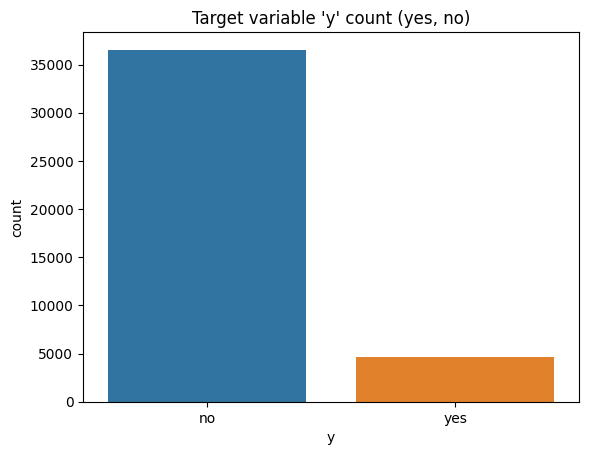

In [8]:
plt.title("Target variable 'y' count (yes, no)")
sns.countplot(data=df, x='y');

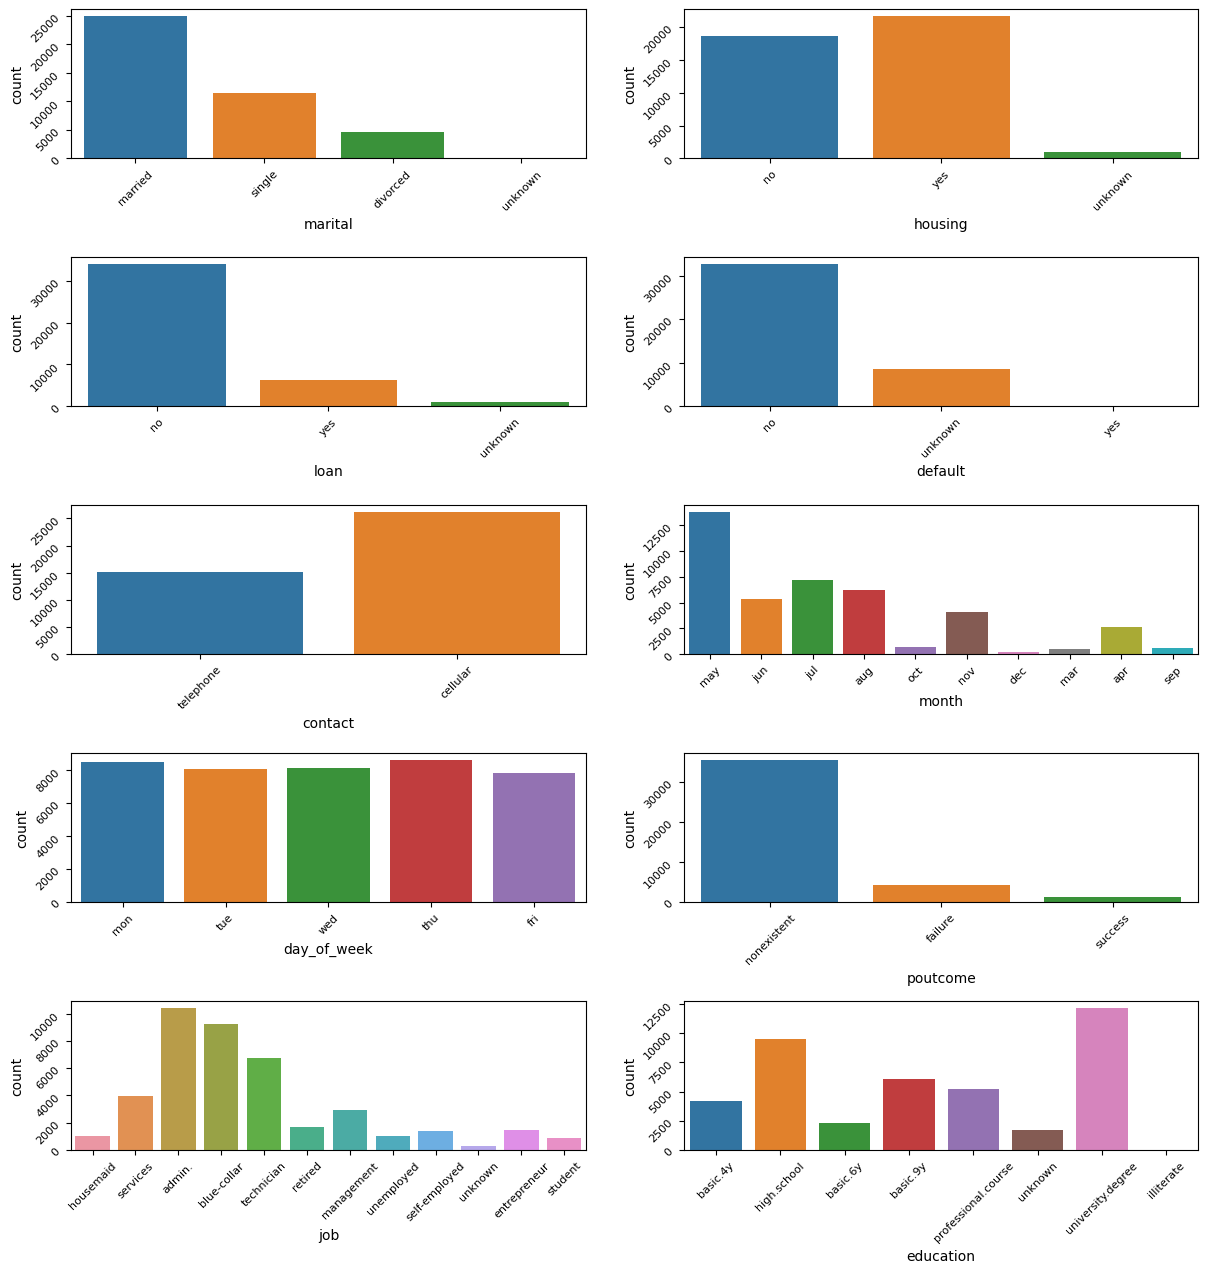

In [9]:
categorical_features = ['marital','housing','loan','default','contact','month','day_of_week','poutcome','job','education']
row_idx = 0
col_idx = 0
idx = 0
fig, ax = plt.subplots(5,2,figsize=(12, 12))
fig.tight_layout(h_pad=5.0,w_pad=4.0)

while row_idx<5:
    col_idx = 0
    while col_idx<2:
        ax[row_idx,col_idx].tick_params(labelrotation=45,labelsize=8)
        ax[row_idx,col_idx].set_xlabel(categorical_features[idx].upper())

        sns.countplot(data=df, x=categorical_features[idx],ax=ax[row_idx,col_idx]);
        col_idx += 1
        idx += 1

    row_idx += 1

##### Numerical columns

In [10]:
numerical_cols = ['age','duration', 'campaign', 'pdays',
       'previous', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed']

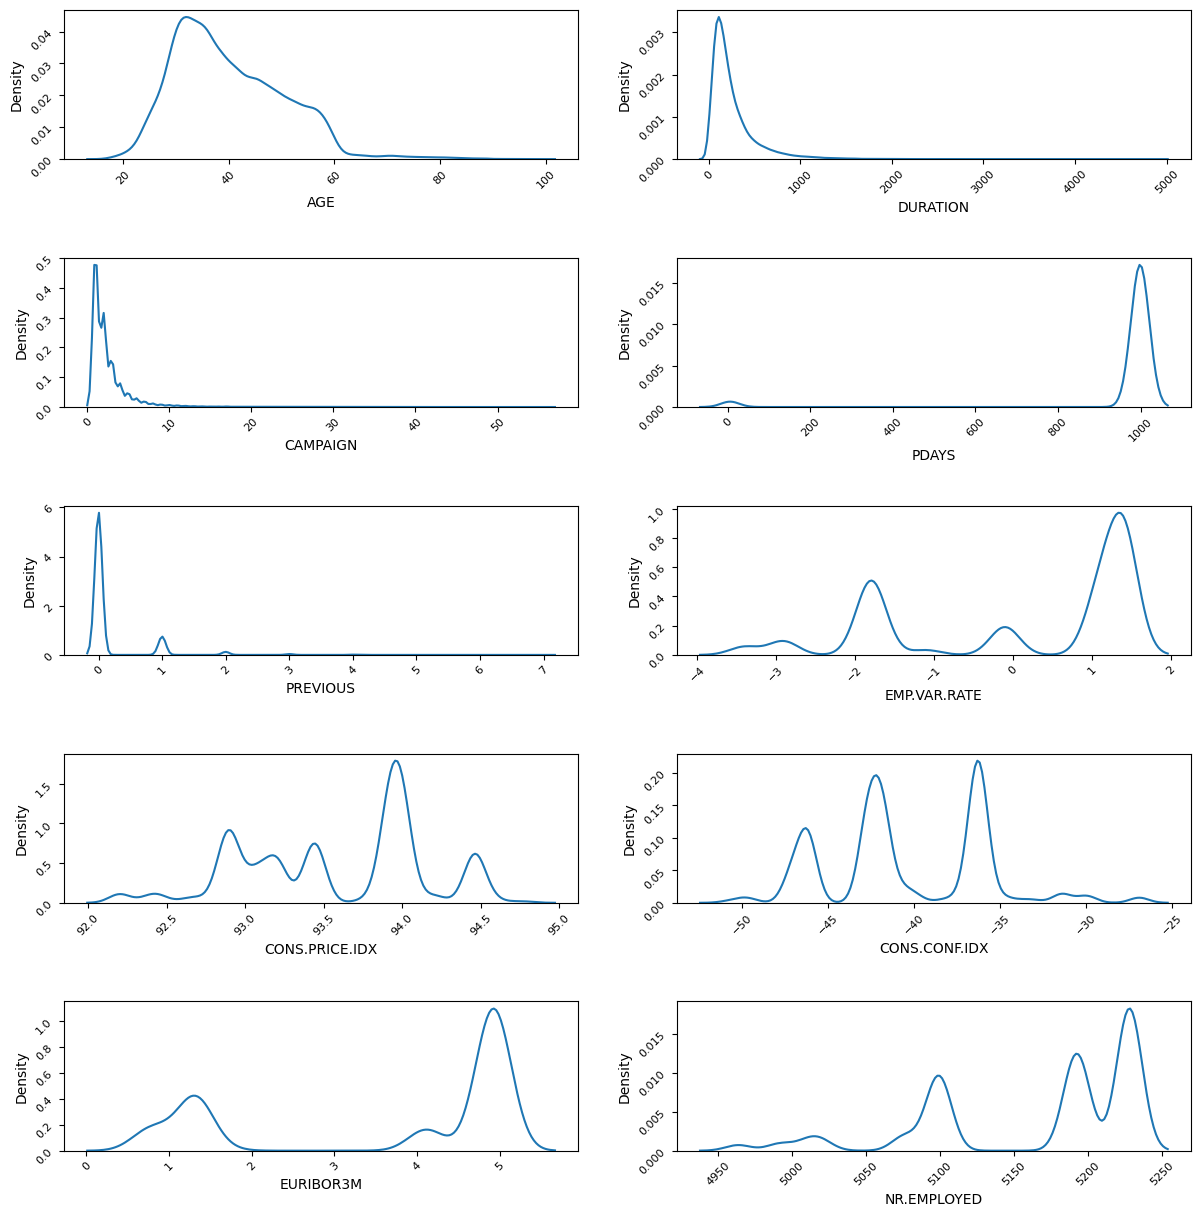

In [11]:
row_idx = 0
col_idx = 0
idx = 0
fig, ax = plt.subplots(5,2,figsize=(12, 12))
fig.tight_layout(h_pad=5.0,w_pad=4.0)

while row_idx<5:
    col_idx = 0
    while col_idx<2:
        ax[row_idx,col_idx].tick_params(labelrotation=45,labelsize=8)
        ax[row_idx,col_idx].set_xlabel(numerical_cols[idx].upper())

        sns.kdeplot(data=df, x=numerical_cols[idx],ax=ax[row_idx,col_idx]);
        col_idx += 1
        idx += 1

    row_idx += 1

# 2.4 Task 4 – EDA, Preprocessing

#### Several categorical columns has missing values in the form of word 'unknown' so dropping rows with it before IDA on independent columns

In [12]:
categorical_features = ['marital','housing','loan','default','contact','month','day_of_week','poutcome','job','education']
for feature in categorical_features:
    df = df[df[feature] != 'unknown']

- Transforming the target feature **y** into 0 and 1 (0=no, 1=yes)

In [13]:
df['y'] = df['y'].replace({'no':0,'yes':1})

#### Checking all the categorical columns to explore their categories and encode them as numbers so that they could be ready for training machine learning models

In [14]:
df['marital'].value_counts()

married     17492
single       9443
divorced     3553
Name: marital, dtype: int64

- Feature 'marital' transforming as dummy variables 

In [15]:
df = pd.get_dummies(data=df, columns=['marital'])
df.columns

Index(['age', 'job', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'y', 'marital_divorced', 'marital_married',
       'marital_single'],
      dtype='object')

In [16]:
df['housing'].value_counts()

yes    16521
no     13967
Name: housing, dtype: int64

- Transforming feature **housing** as 0 and 1 (0=no, 1=yes)

In [17]:
df['housing'] = df['housing'].replace({"yes":1,"no":0})

In [18]:
df['loan'].value_counts()

no     25720
yes     4768
Name: loan, dtype: int64

- Transforming feature **loan** as 0 and 1 (0=no, 1=yes)

In [19]:
df['loan'] = df['loan'].replace({"yes":1,"no":0})

In [20]:
df['default'].value_counts()

no     30485
yes        3
Name: default, dtype: int64

In [21]:
idx = df['default'].value_counts().index
values = df['default'].value_counts().values
shares = list(map(lambda x:x/df.shape[0]*100,values))

list(zip(idx,shares))

[('no', 99.99016006297559), ('yes', 0.009839937024403044)]

- Feature **default** has less than 0.01% records belonging to category **yes** so this feature can't be significant to the target variable in this dataset so, dropping the feature.

In [22]:
df = df.drop(labels='default',axis=1)

In [23]:
df['contact'].value_counts()

cellular     20443
telephone    10045
Name: contact, dtype: int64

- Feature **contact** is transformed to 0 and 1 (0=cellular, 1=telephone)

In [24]:
df['contact'] = df['contact'].replace({"telephone":1,"cellular":0})

In [25]:
df['month'].value_counts()

may    9733
jul    5081
aug    4673
jun    3614
nov    3496
apr    2115
oct     642
sep     495
mar     482
dec     157
Name: month, dtype: int64

- The feature **month** has 12 months as categories which need to be transformed into 12 new columns as dummy variables
- This would increase significantly increase the dimensionality
- We also have many other features in the dataset so, doing a compromise by dropping **month** 

In [26]:
df = df.drop(labels='month',axis=1)

In [27]:
df['day_of_week'].value_counts()

thu    6395
mon    6279
wed    6125
tue    5955
fri    5734
Name: day_of_week, dtype: int64

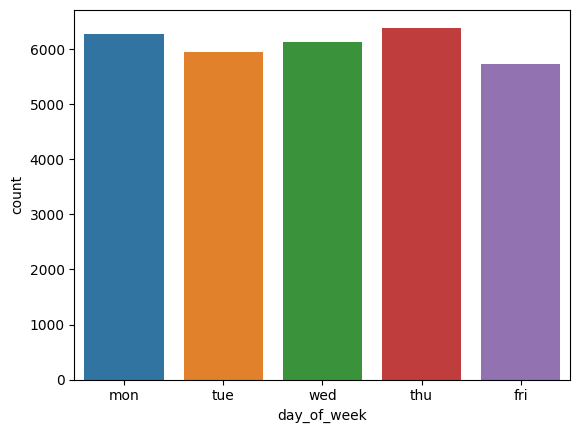

In [28]:
sns.countplot(data=df,x='day_of_week');

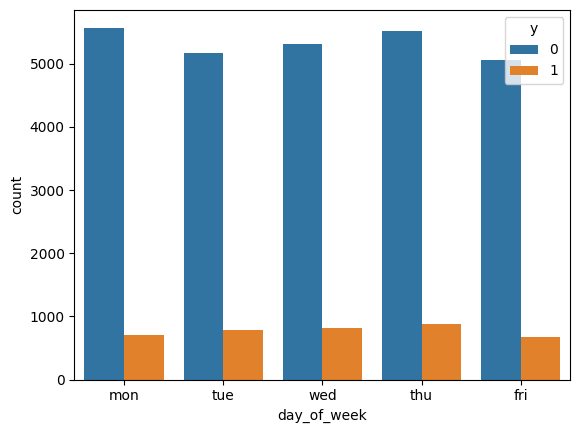

In [29]:
sns.countplot(data=df,x='day_of_week',hue='y');

- The feature **day_of_week** has 5 weekdays as categories and their distribution between **yes** and **no** target labels is quite similar.
- This means this feature doesn't actually help us to predict/categorize target labels so, dropping it

In [30]:
df = df.drop(labels='day_of_week',axis=1)

In [31]:
df['poutcome'].value_counts()

nonexistent    25836
failure         3461
success         1191
Name: poutcome, dtype: int64

- Transforming the feature **poutcome** as dummy variables 

In [32]:
df = pd.get_dummies(data=df, columns=['poutcome'])
df.columns

Index(['age', 'job', 'education', 'housing', 'loan', 'contact', 'duration',
       'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'marital_divorced',
       'marital_married', 'marital_single', 'poutcome_failure',
       'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')

In [33]:
df['job'].value_counts()

admin.           8737
blue-collar      5675
technician       5473
services         2857
management       2311
retired          1216
self-employed    1092
entrepreneur     1089
unemployed        738
housemaid         690
student           610
Name: job, dtype: int64

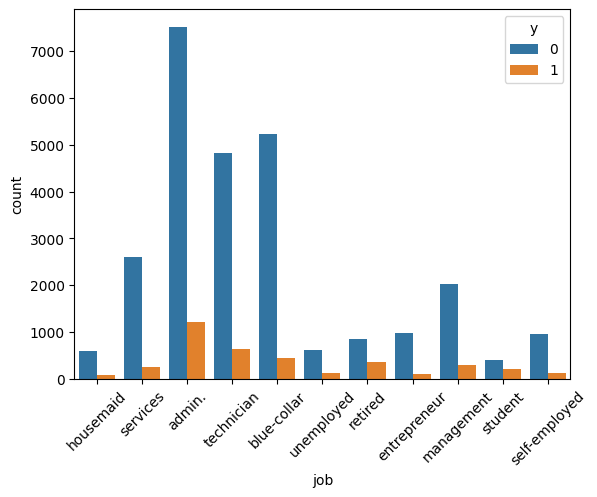

In [34]:
plt.xticks(rotation=45)
sns.countplot(data=df,x='job',hue='y');

- To reduce the dimensionality complexity that would be created from doing dummy variables from the feature **job**, we are going to bin all categories into 2 new categories: **employed** and **unemployed** 
- Unemployed category would have: unemployed, retired and student and rest in employed category
- After that transforming new categories to 0 and 1 (0=unemployed, 1=employed)

In [35]:
def transform_job(rec):
    if rec in ['housemaid','admin.','blue-collar','technician','services','management','self-employed','entrepreneur']:
        rec = 'employed'
    else:
        rec = 'unemployed'
    return rec
df['job']= df['job'].apply(transform_job)

In [36]:
df['job'].value_counts()

employed      27924
unemployed     2564
Name: job, dtype: int64

In [37]:
df['job'] = df['job'].replace({'employed':1, 'unemployed':0})

'contact','month','day_of_week','poutcome','job','education'

In [38]:
df['education'].value_counts()

university.degree      10412
high.school             7699
professional.course     4321
basic.9y                4276
basic.4y                2380
basic.6y                1389
illiterate                11
Name: education, dtype: int64

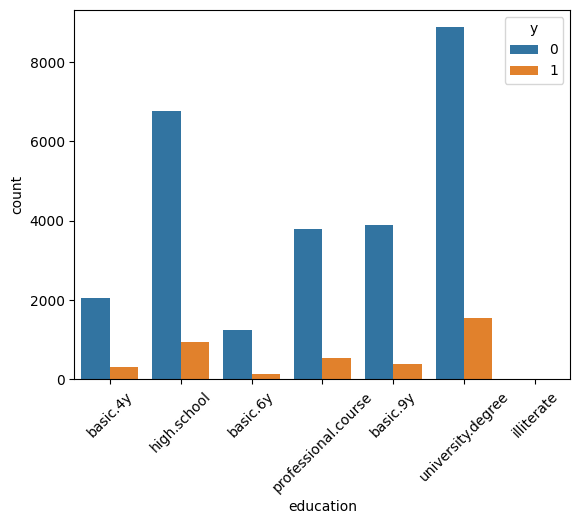

In [39]:
plt.xticks(rotation=45)
sns.countplot(data=df, x='education',hue='y');

In [40]:
# drop education for since it would increase model complexity and we have a lot more features to use
df = df.drop(labels='education',axis=1)

#### Checking if all the features are transformed in relevant data type

In [41]:
df.head()

,age,job,housing,loan,contact,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,1,0,0,1,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,1,0,0,1,0
2,37,1,1,0,1,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,1,0,0,1,0
3,40,1,0,0,1,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,1,0,0,1,0
4,56,1,0,1,1,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,1,0,0,1,0
6,59,1,0,0,1,139,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,1,0,0,1,0


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30488 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   30488 non-null  int64  
 1   job                   30488 non-null  int64  
 2   housing               30488 non-null  int64  
 3   loan                  30488 non-null  int64  
 4   contact               30488 non-null  int64  
 5   duration              30488 non-null  int64  
 6   campaign              30488 non-null  int64  
 7   pdays                 30488 non-null  int64  
 8   previous              30488 non-null  int64  
 9   emp.var.rate          30488 non-null  float64
 10  cons.price.idx        30488 non-null  float64
 11  cons.conf.idx         30488 non-null  float64
 12  euribor3m             30488 non-null  float64
 13  nr.employed           30488 non-null  float64
 14  y                     30488 non-null  int64  
 15  marital_divorced   

In [43]:
df.shape

(30488, 21)

#### Separting dependent target variable and independent features into variables X and y

In [44]:
y= df['y']
X = df.drop(labels='y',axis=1)

In [45]:
X.shape, y.shape

((30488, 20), (30488,))

#### Standard scaling of independent features

In [46]:
scaler =  StandardScaler()
X_scaled_arr = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled_arr,columns=X.columns)
X_scaled.head()

,age,job,housing,loan,contact,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_nonexistent,poutcome_success
0,1.642253,0.303019,-1.087593,-0.430559,1.426584,0.005792,-0.559335,0.211887,-0.371616,0.727477,0.804095,0.877451,0.786102,0.401648,-0.363194,0.861956,-0.669855,-0.357851,0.424333,-0.201625
1,-0.196452,0.303019,0.919461,-0.430559,1.426584,-0.127944,-0.559335,0.211887,-0.371616,0.727477,0.804095,0.877451,0.786102,0.401648,-0.363194,0.861956,-0.669855,-0.357851,0.424333,-0.201625
2,0.093870,0.303019,-1.087593,-0.430559,1.426584,-0.414520,-0.559335,0.211887,-0.371616,0.727477,0.804095,0.877451,0.786102,0.401648,-0.363194,0.861956,-0.669855,-0.357851,0.424333,-0.201625
3,1.642253,0.303019,-1.087593,2.322562,1.426584,0.181559,-0.559335,0.211887,-0.371616,0.727477,0.804095,0.877451,0.786102,0.401648,-0.363194,0.861956,-0.669855,-0.357851,0.424333,-0.201625
4,1.932575,0.303019,-1.087593,-0.430559,1.426584,-0.460373,-0.559335,0.211887,-0.371616,0.727477,0.804095,0.877451,0.786102,0.401648,-0.363194,0.861956,-0.669855,-0.357851,0.424333,-0.201625


#### We have 20 features and a target variable after transformation and preprocessing of the data

# 2.5 Task 5 – A First Impression

#### Splitting the data with test size = 30%

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, random_state = 100,shuffle=True, stratify=y )
print('Shape of X_train {}\nShape of X_test = {}\nShape of y_train = {}\nShape of y_test = {} '\
       .format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))

Shape of X_train (21341, 20)
Shape of X_test = (9147, 20)
Shape of y_train = (21341,)
Shape of y_test = (9147,) 


#### Choosing Uniform Dummy Classifier as a baseline model

In [48]:
# baseline model algorithm selected is uniform
baseline_model = DummyClassifier(strategy="uniform")
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)

#### Using classification report to see performance of the baseline model on different metrics

In [49]:
print("Classification Report for baseline model:\n{}\n"
       .format(classification_report(y_test, y_pred)))

Classification Report for baseline model:
              precision    recall  f1-score   support

           0       0.87      0.49      0.63      7989
           1       0.12      0.48      0.19      1158

    accuracy                           0.49      9147
   macro avg       0.49      0.49      0.41      9147
weighted avg       0.77      0.49      0.57      9147




#### We have imbalanced data so, undersampling the data to make target variables 50-50 in share

In [50]:
rand_sampler = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rand_sampler.fit_resample(X_train, y_train)

In [51]:
Counter(y_resampled)

Counter({0: 2701, 1: 2701})

In [52]:
# baseline model algorithm selected is uniform
baseline_model = DummyClassifier(strategy="uniform", random_state=0)
baseline_model.fit(X_resampled, y_resampled)
y_pred = baseline_model.predict(X_test)

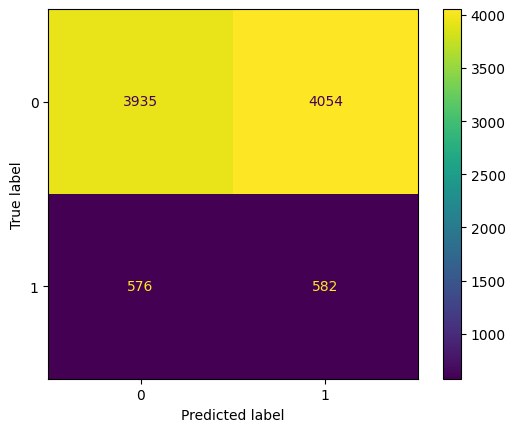

In [53]:
# confusion matrix to  show true and false positives and negatives in the predicted test data
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

In [54]:
print("Classification Report for baseline model (on undersampled data):\n{}\n"
       .format(classification_report(y_test, y_pred)))

Classification Report for baseline model (on undersampled data):
              precision    recall  f1-score   support

           0       0.87      0.49      0.63      7989
           1       0.13      0.50      0.20      1158

    accuracy                           0.49      9147
   macro avg       0.50      0.50      0.42      9147
weighted avg       0.78      0.49      0.58      9147




#### Performance on baseline Model on test data

- For class label '0' (No), precision = 0.87, recall = 0.49, f1-score = 0.63
- For class label '1' (Yes), precision = 0.13, recall = 0.50, f1-score = 0.20
- Accuracy = 0.49

- From the above baseline performance metrics, it is quite observant that the precision,recall and f1-score for label '1' (yes) are quite low, also for label '0' recall is quite bad.
- Even though the performance didn't change a lot with resampled data, with other advanced algorithms I am positive that resampling plays a crucial role.


# 2.6 Task 6 – Algorithms and their Parameters

**3 algorithms for classification**
- KNN
- SVM
- XGBoost Decision Tree Classifier (Using this algorithm to boost performance, great for high dimensional data and handling outliers )

**Note**: All models will be trained on resampled data (refer section 2.5)

#### Define functions to train & evaluate machine learning models, and plot their performance

In [87]:
def train_model(model,Xt,yt,X_test,y_test):
    """
        The function takes classifier model, training and test data as input arguments,
        train the classifier with the training data,
        evaluate accuracy, recall and f1 score on test data,
        return performance scores in a tuple
    """
    model.fit(Xt,yt)
    y_pred = model.predict(X_test)
    recall = recall_score(y_test, y_pred, average='macro')
    return recall

In [56]:
def plot_performance(dframe,model_name,x_label,hue_label=None):
    """
        The function takes pandas dataframe consisting performance score of the classifier model as a input,
        it also takes the classifier name as a second argument,
        plot recall score 
    """
    plt.title('Recall vs {} ({})'.format(x_label, model_name))
    sns.lineplot(data=dframe, x=x_label,y='recall_score', hue=hue_label, palette='Set2')
    plt.show()

In [57]:
def getTopParameter(dframe, param):
    """
        This function takes a dataframe and parameter to find the optimal parameter within a grid of parameters
        defined in the dataframe,
        returns the optimal parameter having the highest recall_score 
    """
    idx = np.argmax(dframe['recall_score'])
    return dframe.iloc[idx][param]

#### KNN performance evaluation on different values of hyperparameters

In [88]:
results = {'distance':\
           {'recall':[]}, 'uniform':{'recall':[]}\
            ,'n_neighbors':np.arange(2,100) }

for k in results['n_neighbors']:

    # for uniform weighted KNN
    knn_uniform = KNeighborsClassifier(weights='uniform', n_neighbors=k)
    metrics_results = train_model(knn_uniform,X_resampled,y_resampled,X_test,y_test)
    results['uniform']['recall'].append(metrics_results)
    
    # for distance weighted KNN
    knn_distance = KNeighborsClassifier(weights='distance', n_neighbors=k)
    metrics_results = train_model(knn_distance,X_resampled,y_resampled,X_test,y_test)
    results['distance']['recall'].append(metrics_results)
    

In [89]:
# dataframe for uniform weighted knn
results_uniform_df = pd.DataFrame(columns=['k','weight','balanced_accuracy','f1_score'])
results_uniform_df['recall_score'] = results['uniform']['recall']
results_uniform_df['weight'] = 'uniform'
results_uniform_df['k'] = results['n_neighbors']

# dataframe for distance weighted knn 
results_distance_df = pd.DataFrame(columns=['k','weight','balanced_accuracy','f1_score'])
results_distance_df['recall_score'] = results['distance']['recall']
results_distance_df['weight'] = 'distance'
results_distance_df['k'] = results['n_neighbors']

# dataframe to concatenate both dataframes
results_df = pd.concat([results_uniform_df, results_distance_df],axis=0)

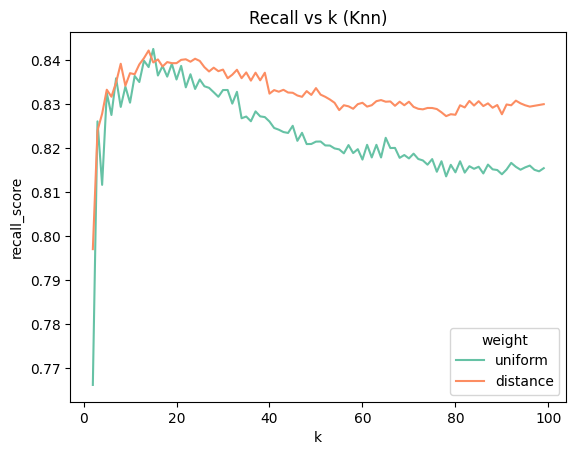

In [90]:
plot_performance(results_df, 'Knn','k','weight')

In [86]:
# finding n_neighbors where the recall is the highest 
k = getTopParameter(results_uniform_df, 'k')
print('Max recall at n_neigbors (uniform) = ',k)

k = getTopParameter(results_distance_df, 'k')
print('Max recall at n_neigbors (distance) = ',k)

Max recall at n_neigbors (uniform) =  3
Max recall at n_neigbors (distance) =  2


**Interpretation of performance of KNN at different values of hyperparameters**

- Weight = **distance** and performing better than uniform
- Range of N_neighbors should be centered around  N_neighbors = 14 (later for cross validation)

#### SVM performance evaluation on different values of hyperparameters

In [62]:
results = {'poly':\
           {'recall':[]}, 'rbf':{'recall':[]}\
            ,'Cs': (0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1,2, 10, 20, 50, 100,)}


for k in results['Cs']:

    # for rbf kernel
    svc_rbf = SVC(kernel='rbf', C=k, random_state=0)
    metrics_results = train_model(svc_rbf,X_resampled,y_resampled,X_test,y_test)
    results['rbf']['recall'].append(metrics_results)
    
    # for poly kernel
    svc_linear = SVC(kernel='poly', C=k, random_state=0)
    metrics_results = train_model(svc_linear,X_resampled,y_resampled,X_test,y_test)
    results['poly']['recall'].append(metrics_results)

In [63]:
# dataframe for poly svc
results_poly_df = pd.DataFrame(columns=['C','kernel','recall_score',])
results_poly_df['recall_score'] = results['poly']['recall']
results_poly_df['kernel'] = 'poly'
results_poly_df['C'] = results['Cs']

# dataframe for rbf svc
results_rbf_df = pd.DataFrame(columns=['C','rbf','balanced_accuracy','f1_score'])
results_rbf_df['recall_score'] = results['rbf']['recall']
results_rbf_df['kernel'] = 'rbf'
results_rbf_df['C'] = results['Cs']

# dataframe to concatenate both dataframes
results_df = pd.concat([results_poly_df, results_rbf_df],axis=0)

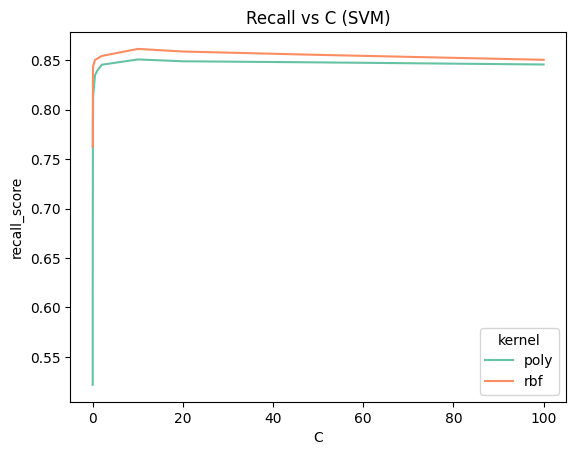

In [64]:
plot_performance(results_df, 'SVM','C','kernel')

In [65]:
k = getTopParameter(results_poly_df, 'C')
print('Max recall at C (poly)= ',k)

k = getTopParameter(results_rbf_df, 'C')
print('Max recall at C (rbf)= ',k)

Max recall at C (poly)=  10.0
Max recall at C (rbf)=  10.0


In [66]:
results = {'rbf':\
           {'recall':[]}, 'rbf':{'recall':[]},\
            'gamma': (0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1)}

for k in results['gamma']:

    # for rbf kernel
    svc_rbf = SVC(kernel='rbf', gamma=k, random_state=0)
    metrics_results = train_model(svc_rbf,X_resampled,y_resampled,X_test,y_test)
    results['rbf']['recall'].append(metrics_results)

# dataframe for rbf svc
results_rbf_df = pd.DataFrame(columns=['gamma','rbf','recall_score'])
results_rbf_df['recall_score'] = results['rbf']['recall']
results_rbf_df['kernel'] = 'rbf'
results_rbf_df['gamma'] = results['gamma']

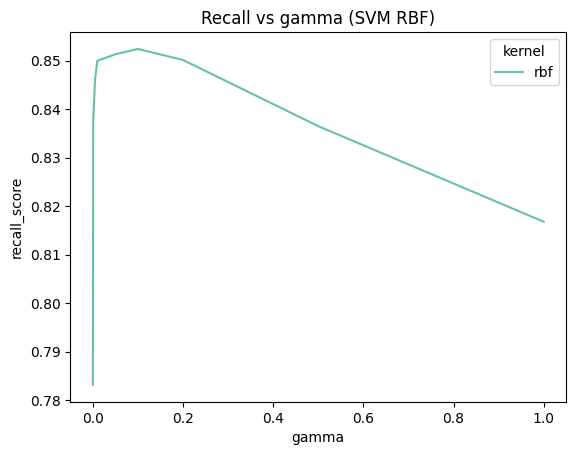

In [67]:
plot_performance(results_rbf_df, 'SVM RBF','gamma','kernel')

In [68]:
k = getTopParameter(results_rbf_df, 'gamma')
print('Max recall at gamma (rbf)= ',k)

Max recall at gamma (rbf)=  0.1


In [69]:
results = {'poly':\
           {'recall':[]},\
            'degree': np.arange(2,30)}

for k in results['degree']:
    
    # for poly kernel
    svc_poly = SVC(kernel='poly', degree=k, random_state=0)
    metrics_results = train_model(svc_poly,X_resampled,y_resampled,X_test,y_test)
    results['poly']['recall'].append(metrics_results)

# dataframe for poly svc
results_poly_df = pd.DataFrame(columns=['gamma','kernel','recall'])
results_poly_df['recall_score'] = results['poly']['recall']
results_poly_df['kernel'] = 'poly'
results_poly_df['degree'] = results['degree']

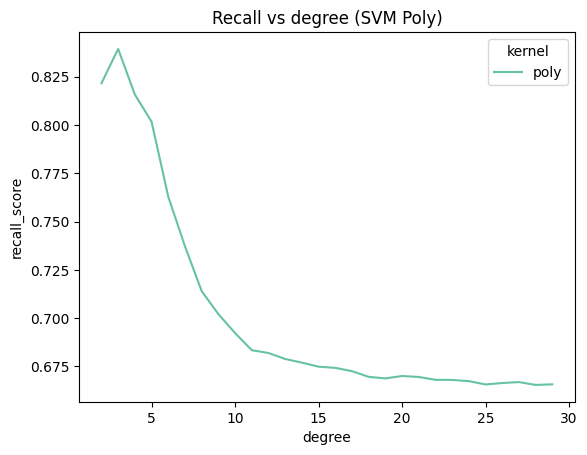

In [70]:
plot_performance(results_poly_df, 'SVM Poly','degree','kernel')

In [71]:
k = getTopParameter(results_poly_df, 'degree')
print('Max recall at degree (poly)= ',k)

Max recall at degree (poly)=  3


**Interpretation of gamma and C hyperparameters for SVC**

- Kernel **rbf** gamma parameters grid should be centered around 0.1
- Kernel **rbf** performs better than **poly** at different values of C
- For both kernels C parameters grid should be centered around 10
- Kernel **poly** has the maximum recall score at degree 3
- Right hyperparameters combination can be found later on after cross validation

#### XGBoost performance evaluation on different values of hyperparameters

In [72]:
results = {'recall':[],\
            'max_depth':np.arange(2,30)}

for k in results['max_depth']:

    xgb = XGBClassifier(max_depth=k, random_state=0)
    metrics_results = train_model(xgb,X_resampled,y_resampled,X_test,y_test)
    results['recall'].append(metrics_results)

In [73]:
# dataframe for xgb performance
results_df = pd.DataFrame(columns=['max_depth','recall'])
results_df['recall_score'] = results['recall']
results_df['max_depth'] = results['max_depth']

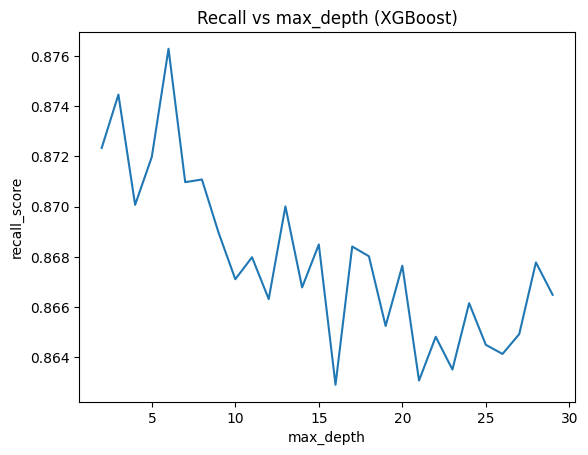

In [74]:
plot_performance(results_df, 'XGBoost','max_depth');

In [75]:
k = getTopParameter(results_df, 'max_depth')
print('Max recall at max_depth = ',k)

Max recall at max_depth =  6


In [76]:
results = {'recall':[],
            'n_estimators':[1, 2, 3, 4, 5, 10, 20, 50, 100, 150, 180, 200]}

for k in results['n_estimators']:

    xgb = XGBClassifier(n_estimators=k, random_state=0)
    metrics_results = train_model(xgb,X_resampled,y_resampled,X_test,y_test)
    results['recall'].append(metrics_results)


In [77]:
results_df = pd.DataFrame(columns=['n_estimators','recall'])
results_df['recall_score'] = results['recall']
results_df['n_estimators'] = results['n_estimators']

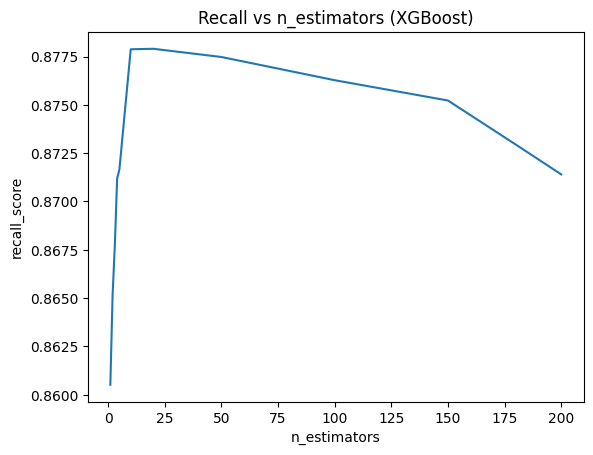

In [78]:
plot_performance(results_df, 'XGBoost','n_estimators');

In [79]:
k = getTopParameter(results_df, 'n_estimators')
print('Max recall at n_estimators = ',k)

Max recall at n_estimators =  20


In [80]:
results = {'recall':[],\
            'learning_rate':(0.00001, 0.00005, 0.0001, 0.001, 0.005, 0.0075, 0.01,0.05,0.1,0.5,1,2,3,4,10,20,30)}

for k in results['learning_rate']:

    xgb = XGBClassifier(learning_rate=k, random_state=0)
    metrics_results = train_model(xgb,X_resampled,y_resampled,X_test,y_test)
    results['recall'].append(metrics_results)

results_df = pd.DataFrame(columns=['learning_rate','recall'])
results_df['recall_score'] = results['recall']
results_df['learning_rate'] = results['learning_rate']

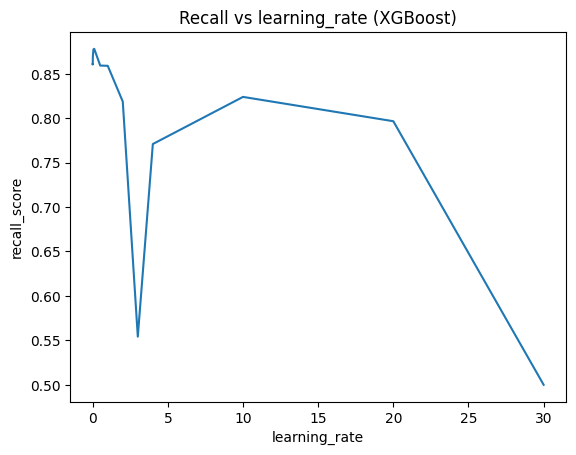

In [81]:
plot_performance(results_df, 'XGBoost','learning_rate');

In [82]:
k = getTopParameter(results_df, 'learning_rate')
print('Max recall at learning_rate = ',k)

Max recall at learning_rate =  0.1


**Interpretation of XGBoost hyperparameters**

- The max_depth of the trees in XGBoost should be centered around max_depth = 6
- The n_estimators in the XGBoost should be centered around 20
- Learning rate should be centered around 0.1

# 2.7 Task 7 – Nested Cross Validation

In [53]:
# num of trials for nested cv
NUM_TRIALS = 3
# Number of times cv to be repeated.
NUM_INNER_REPEATS=3 
# number of splits in inner cv
NUM_INNER_SPLITS=10 
# number of splits in outer cv
NUM_OUTER_SPLITS=10
# performance metrics
PERF_METRICS = ['balanced_accuracy','recall','f1']

In [1]:
# metrics based on which the comparison of all algorithms would be done
METRICS = ['name','bacc_min','bacc_max','bacc_mean','bacc_std',\
                    'recall_min','recall_max','recall_mean','recall_std',\
                    'f1_min','f1_max','f1_mean','f1_std',\
                    'fit_time(avg)','test_time(avg)']

In [85]:
# reference from the Machine Learning lecture
def run_nested_cv(estimator, grid_params, x, y):
    """
       This function accepts machine learning model, grid of parameters for the model, features and target variables as arguments.
       Inner and outer cv are run using the machine learning model and are evaluated on different metrics and parameters 
       Function returns performance results after fitting the model 
    """
    baccs = np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    f1 = np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    recall = np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    fit_times= np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    test_times=np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    start = time.time()

    for i in range(NUM_TRIALS):
        print("Running Outer CV in iteration: ", i, " at ", time.time()-start, "s")
        # inner cv
        inner_cv = RepeatedStratifiedKFold(n_splits=NUM_INNER_SPLITS, n_repeats=NUM_INNER_REPEATS, random_state=i)
        # outer cv
        outer_cv = StratifiedKFold(n_splits=NUM_OUTER_SPLITS, shuffle=True, random_state=i)
        # grid_searchcv
        # refit on recall because recall is the most important metric for our business problem/dataset
        model = GridSearchCV(estimator=estimator, param_grid=grid_params, cv=inner_cv, scoring=PERF_METRICS, n_jobs=-1, refit="recall")
        model_results = cross_validate(model, X=x, y=y, cv=outer_cv, scoring=PERF_METRICS, n_jobs=-1)
    
        baccs[i] = model_results["test_balanced_accuracy"]
        f1[i] = model_results["test_f1"]
        recall[i] = model_results["test_recall"]
        fit_times[i]=model_results['fit_time']
        test_times[i]=model_results['score_time']
    
    print ("Total time: ", (time.time()-start),  "s")
    return  baccs, recall, f1, fit_times, test_times

In [86]:
def concatenate_evaluation_metrics(dframe, name, baccs, f1,  recall, fit_times, test_times):
    """
       The function accepts pandas dataframe with previous performance results, model name, accuracy, f1, recall results, training and test times
       as arguments.
       The function returns updated dataframe of performance results
    """
    
    data = [name, baccs.min(), baccs.max(), baccs.mean(), baccs.std(),\
            recall.min(),recall.max(),recall.mean(),recall.std(),\
            f1.min(),f1.max(),f1.mean(),f1.std(),\
            fit_times.mean(),test_times.mean()]
    
    new_dframe = pd.DataFrame(data=[data],columns=METRICS)
    
    return pd.concat([dframe, new_dframe], ignore_index=True, axis=0)

In [87]:
# dataframe for showing all the performance results for all algorithms
nested_cv_results_df = pd.DataFrame(columns=METRICS)

### KNN Nested CV

In [89]:
grid_params = {"weights": ['uniform', 'distance'],"n_neighbors": range(10,21)}
knn = KNeighborsClassifier()
baccs, f1, recall, fit_times, test_times = run_nested_cv(knn, grid_params, X_resampled, y_resampled)
nested_cv_results_df = concatenate_evaluation_metrics(nested_cv_results_df, "KNN", baccs,f1, recall, fit_times, test_times)

Running Outer CV in iteration:  0  at  1.1920928955078125e-06 s
Running Outer CV in iteration:  1  at  56.26253056526184 s
Running Outer CV in iteration:  2  at  110.21782112121582 s
Total time:  164.754399061203 s


In [90]:
nested_cv_results_df

,name,bacc_min,bacc_max,bacc_mean,bacc_std,recall_min,recall_max,recall_mean,recall_std,f1_min,f1_max,f1_mean,f1_std,fit_time(avg),test_time(avg)
0,KNN,0.801852,0.874306,0.835371,0.015869,0.79619,0.874074,0.835591,0.016766,0.774074,0.885185,0.837352,0.025033,31.199376,0.04789


### SVM POLY Nested CV

In [91]:
# grid of parameters are adjusted according to the recall vs parameter plots (2.6) 
grid_params = {"degree": np.arange(1,8),\
               'C': (1,5,7,10,13,15,20) }
svc_poly = SVC(kernel='poly',random_state=0)
baccs, f1, recall, fit_times, test_times = run_nested_cv(svc_poly, grid_params, X_resampled, y_resampled)
nested_cv_results_df = concatenate_evaluation_metrics(nested_cv_results_df, "SVM poly", baccs,f1, recall, fit_times, test_times)

Running Outer CV in iteration:  0  at  2.384185791015625e-06 s
Running Outer CV in iteration:  1  at  2977.3909499645233 s
Running Outer CV in iteration:  2  at  6070.818870782852 s
Total time:  9163.10274362564 s


### SVM RBF Nested CV

In [92]:
# grid of parameters are adjusted according to the recall vs parameter plots (2.6) 
grid_params = {"gamma": (0.01, 0.05, 0.1, 0.5,1),\
               'C': (1,5,7,10,13,15,20) }
svc_rbf = SVC(kernel='rbf',random_state=0)
baccs, f1, recall, fit_times, test_times = run_nested_cv(svc_rbf, grid_params, X_resampled, y_resampled)
nested_cv_results_df = concatenate_evaluation_metrics(nested_cv_results_df, "SVM rbf", baccs,f1, recall, fit_times, test_times)

Running Outer CV in iteration:  0  at  4.5299530029296875e-06 s
Running Outer CV in iteration:  1  at  2233.429489850998 s
Running Outer CV in iteration:  2  at  4498.831146001816 s
Total time:  6774.688199043274 s


### XGBoost Nested CV

In [93]:
# grid of parameters are adjusted according to the recall vs parameter plots (2.6) 
grid_params = {
     'max_depth':np.arange(2,11),
      'learning_rate':(0.01, 0.05, 0.075, 0.1, 0.125, 0.15,0.2),
     'n_estimators':[10,15,18,20,23,25]   
}

xgb = XGBClassifier(random_state=0)
baccs, f1, recall, fit_times, test_times = run_nested_cv(xgb, grid_params, X_resampled, y_resampled)
nested_cv_results_df = concatenate_evaluation_metrics(nested_cv_results_df, "XGBoost", baccs,f1, recall, fit_times, test_times)

Running Outer CV in iteration:  0  at  5.9604644775390625e-06 s
Running Outer CV in iteration:  1  at  3283.415322303772 s
Running Outer CV in iteration:  2  at  6560.636127233505 s
Total time:  9849.211339950562 s


In [95]:
nested_cv_results_df

,name,bacc_min,bacc_max,bacc_mean,bacc_std,recall_min,recall_max,recall_mean,recall_std,f1_min,f1_max,f1_mean,f1_std,fit_time(avg),test_time(avg)
0,KNN,0.801852,0.874306,0.835371,0.015869,0.796190,0.874074,0.835591,0.016766,0.774074,0.885185,0.837352,0.025033,31.199376,0.047890
1,SVM poly,0.818519,0.892804,0.847520,0.017857,0.821168,0.893382,0.849899,0.017016,0.833333,0.900000,0.863015,0.018182,2088.341535,0.262645
2,SVM rbf,0.788889,0.842975,0.816794,0.013710,0.807692,0.850420,0.831540,0.011799,0.855556,0.940741,0.904114,0.018837,1542.597317,0.714937
3,XGBoost,0.781481,0.891041,0.858499,0.023397,0.810289,0.896309,0.868822,0.018607,0.892593,0.955556,0.934341,0.014357,2222.387224,0.033575


### Baseline Model CV

In [103]:
# reference from the Machine Learning lecture
def run_cv(estimator, x, y):
    """
       This function accepts machine learning model , features and target variables as arguments.
       Outer cv is run using the machine learning model and are evaluated on different metrics and parameters 
       Function returns performance results after fitting the model 
    """
    baccs = np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    f1 = np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    recall = np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    fit_times= np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    test_times=np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    start = time.time()

    for i in range(NUM_TRIALS):
        print("Running Outer CV in iteration: ", i, " at ", time.time()-start, "s")
        # outer cv
        outer_cv = StratifiedKFold(n_splits=NUM_OUTER_SPLITS, shuffle=True, random_state=i)
        model_results = cross_validate(estimator, X=x, y=y, cv=outer_cv, scoring=PERF_METRICS, n_jobs=-1)
    
        baccs[i] = model_results["test_balanced_accuracy"]
        f1[i] = model_results["test_f1"]
        recall[i] = model_results["test_recall"]
        fit_times[i]=model_results['fit_time']
        test_times[i]=model_results['score_time']
    
    print ("Total time: ", (time.time()-start),  "s")
    return  baccs, recall, f1, fit_times, test_times

In [104]:
# baseline model algorithm selected is uniform
baseline = DummyClassifier(strategy="uniform", random_state=0)
# running cv without nesting
baccs, f1, recall, fit_times, test_times = run_cv(baseline, X_resampled, y_resampled)
nested_cv_results_df = concatenate_evaluation_metrics(nested_cv_results_df, "Uniform dummy classifier(baseline)", baccs,f1, recall, fit_times, test_times)

Running Outer CV in iteration:  0  at  9.5367431640625e-07 s
Running Outer CV in iteration:  1  at  1.6670987606048584 s
Running Outer CV in iteration:  2  at  1.7271521091461182 s
Total time:  1.7712209224700928 s


In [102]:
nested_cv_results_df

,name,bacc_min,bacc_max,bacc_mean,bacc_std,recall_min,recall_max,recall_mean,recall_std,f1_min,f1_max,f1_mean,f1_std,fit_time(avg),test_time(avg)
0,KNN,0.801852,0.874306,0.835371,0.015869,0.796190,0.874074,0.835591,0.016766,0.774074,0.885185,0.837352,0.025033,31.199376,0.047890
1,SVM poly,0.818519,0.892804,0.847520,0.017857,0.821168,0.893382,0.849899,0.017016,0.833333,0.900000,0.863015,0.018182,2088.341535,0.262645
2,SVM rbf,0.788889,0.842975,0.816794,0.013710,0.807692,0.850420,0.831540,0.011799,0.855556,0.940741,0.904114,0.018837,1542.597317,0.714937
3,XGBoost,0.781481,0.891041,0.858499,0.023397,0.810289,0.896309,0.868822,0.018607,0.892593,0.955556,0.934341,0.014357,2222.387224,0.033575
4,Uniform dummy classifier(baseline),0.508350,0.511111,0.510737,0.000847,0.516364,0.520000,0.519542,0.001096,0.525926,0.529630,0.529064,0.001197,0.002892,0.007295


### Interpretation of nested cv results
- 3 machine learning algorithms were run through nested cv which are: **KNN, SVM (rbf, poly), XGBoost**. Also, baseline model is **uniform dummy** classifier which was run through cv.
- Below are the best and worst performance comparisons excluding the baseline model.

- **Accuracy**
    - **XGBoost** has the highest mean balanced accuracy of **85.84%** and **KNN** model has the least of **83.53%**
    - **SVM rbf** has the least mean standard deviation of **0.013710** in balanced accuracies

- **Recall**
    - **XGBoost** has the highest mean recall of **86.88%** and **SVM rbf** has the least of **83.15%**
    - **SVM rbf** has the least mean standard deviation of **0.011799** between all recall values

- **F1-score**
    - **XGBoost** has the highest mean f1-score of **93.43%** and **KNN** has the least of **83.73%**
    - **XGBoost** has the least mean standard deviation of **0.014357** between all f1 score values

- **Training time**
    - **KNN** takes the least amount of average training time (fit time) and **XGBoost** classifier takes the most time to train
    - **XGBoost** takes the least average testing time while the **SVM rbf** classifier takes the most time to predict/test

- **Baseline dummy classifier**
    - The performance of the baseline model is lower on every metrics except for training and test times compared to other 3 algorithms

### Discussion and Recommendation

- All of the 3 algorithms performed better than the baseline model in all performance metrics
- XGBoost has beaten all other algorithms in every metrics
- Baseline has the least performance in every metrics
- KNN and baseline classifier is the most fastest model to train due to it's simplicity and less no of hypermeters to tune
- SVM rbf and poly both needs quite a lot of time to train because their optimization takes quadratic time (to find optimized hyperplane)
- The training time of all algorithms depends on their optimization method and number of parameters provided to CV
- Even though XGBoost took a bit longer than SVMs, we shouldn't forget the fact that it had 3 parameters keys to tune.
- XGBoost is quite easy to set and tune parameters.
- XGBoost has known for handling large datasets quite efficiently without overfitting.
- XGBoost is quite scalable and efficient that's why it's training time is quite good for such a high performance.

# 2.8 Task 8 – Final Production Model

#### XGBoost is the final winner model as recommended in the above cell

In [55]:
grid_params = {
     'max_depth':np.arange(2,11),
      'learning_rate':(0.01, 0.05, 0.075, 0.1, 0.125, 0.15,0.2),
     'n_estimators':[10,15,18,20,23,25]   
}
final_xgb = XGBClassifier(random_state=0)
outer_cv = RepeatedStratifiedKFold(n_splits=NUM_INNER_SPLITS, n_repeats=NUM_INNER_REPEATS, random_state=100)
clf = GridSearchCV(estimator=final_xgb, param_grid=grid_params, scoring = PERF_METRICS, n_jobs=-1, cv=outer_cv, refit='recall')
clf.fit(X_resampled,y_resampled) 
clf
print('Hypertuned parameters = \n', clf.best_params_)

Hypertuned parameters = 
 {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 20}


In [56]:
# fitting winning model XGB with its hypertined parameters
final_clf = XGBClassifier(learning_rate= 0.05, max_depth= 6, n_estimators= 20, random_state=0)
final_clf.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=20, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

#### Saving the final classifier into a serializable format which can be imported and loaded in the production

In [57]:
import joblib
  
# Save the trained model as a pickle string.
saved_model = joblib.dump(final_clf,'final_model.pkl')

# 2.9 Task 9 – Conclusions and Future Work
- Summarize and interpret the achieved results.
- Critically assess the usability of your approach in the context of your task.
- Explain the generated value.
- Propose ideas for future work (a short sketch or enumeration of ideas is sufficient, no further
experiments)

- **Summary and interpretation:**
    - Running through 4 algorithms including a baseline dummy classifier, XGBoost outperformed all in every performance metrics.  For our problem of predicting the term deposit by a client, a high recall score is crucial. And, XGBoost has a good mean recall score of 86.88%. If we have a good lucky split, then the recall could go upto 89.64%. A recall over 86% means that our final production model would predict about False Negative 14 times out of 100 unique records. This implies that, the bank will lose out to identify 14 high value clients out of 100. High value clients are those who will do the term deposit.
    - The average accuracy of our production model is over 85%. It means 85 times out of 100, we will predict the client's deposit correctly. A high accuracy would help the bank identify low and high value clients with precision.

- **There are several criticism in approaches I've taken in this project which are listed below:**
    - I dropped features education and month to reduce complexity and hoping its not a determining feature for the project, I also dropped day_of_week since its distribution was the same for both target labels. Also, the multivariate job feature was converted into simple binary feature. So, these feature engineering could have been properly assessed by using them in training in their raw form.
    - I used sklearn's randomundersampler to balance the dataset but I went with default 'auto' sampling strategy and didn't try out other options.
    - I didn't check and handle outliers
    - No statistical testing of features were done so we don't know which are the actual significant features in the data
    - There were too many hyperparamters in all the algorithms to tune which I didn't do due to processing power and time limit

-  **Generated value:**
    - With a production machine learning predictor, now we can deploy it and predict if the bank's client would do a term deposit or not. This would let the bank identify it's high value clients and propose them better offers to encourage more deposits from them. Moreover, this is also a future prediction/forecast of the deposit which the bank can use to estimate it's earnings from the deposits. This would be quite useful since the bank can tailor it's investment strategies beforehand. This is save a lot of time hence resources of the bank.

- **Future work:**
    - A detailed analysis of features and advanced feature engineering can boost the performance of machine learning models significantly because the data that goes inside models plays significant role on model's performance. And, statistical testing of features can decrease the complexity of the data and improve the training time hence performance.